# 개요 

참여중인 딥러닝 스터디 6주차 기록입니다.

# 5주차 과제 설명

* Optimizer 비교 : SGD vs adam
  * adam이 1 epoch만에 SGD의 accuracy보다 높게 나옴
    ```
      # SGD
      Epoch 1/5
      1875/1875 [==========] - 6s 3ms/step - loss: 0.6548 - accuracy: 0.8358
      ...
      Epoch 5/5
      1875/1875 [==========] - 5s 2ms/step - loss: 0.2346 - accuracy: 0.9352
      
      # adam
      Epoch 1/5
      1875/1875 [==========] - 11s 6ms/step - loss: 0.2605 - accuracy: 0.9256
      ...
      Epoch 5/5
      1875/1875 [==========] - 7s 4ms/step - loss: 0.0456 - accuracy: 0.9863
    ```

* Overfitting 케이스
  * Test accuracy가 97.75%로 Train accuracy 98.63%보다 낮게 나옴
  * 간단한 데이터이므로 overfitting으로 판단했지만, 실제로 1%의 차이는 거의 일어나지 않은 것
    (실제로 일어나면 5%가까이 떨어지는 경우도 많음)

* Overfitting 케이스 방지 : Dropout 추가
  * Dropout을 통해 여러 특징을 학습시킬 수 있도록 함
    (뉴런을 적게쓰므로 1 epoch에서는 좀 더 낮음)
    ```python
      model2 = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28,28)),
          tf.keras.layers.Dense(128, activation = 'relu'),
          tf.keras.layers.Dropout(0.2), # Dropout : 20%정도 Layer를 끈다
          tf.keras.layers.Dense(10, activation='softmax')
      ])

      ...

      Epoch 1/5
      1875/1875 [==========] - 9s 4ms/step - loss: 0.2939 - accuracy: 0.9154
      ...
      Epoch 5/5
      1875/1875 [==========] - 6s 3ms/step - loss: 0.0725 - accuracy: 0.9772
    ```
  * Test accuracy가 97.85%,  Train accuracy 97.72% 로 Overfitting 줄어듦

* Overfitting 케이스 방지 : Regularization
  * 파라미터에 패널티를 부여해 Overfitting을 방지. 딥러닝에서는 잘 쓰이지 않음
    * `tf.keras.regularizers.l2(0.01)` : $\lambda$값으로 0.01부여, 커질수록 강한 패널티
    ```python
      model2 = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28,28)),
          tf.keras.layers.Dense(128, activation = 'relu'),
          tf.keras.layers.Dense(128, kernel_regularizer = tf.keras.regularizers.l2(0.01), activation = 'relu'),
          tf.keras.layers.Dense(10, activation='softmax')
      ])
    ```
    * Test accuracy가 96.70%,  Train accuracy 97.81% 로 오히려 Underfitting 발생

* Overfitting 케이스 방지 : Early stopping
  * `Early stopping 미적용`
    ```python
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(500, input_dim=2, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])

      model.compile(loss='binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])
                    
      history = model.fit(trainX, trainy, validation_data = (trainX_2, trainy_2), # test데이터를 validation에 넣지 않는다
                      epochs=4000, verbose=0)

      >>> Train acc: 1.0, Test acc: 0.9142857193946838
    ```

  * `Early stopping without patience`
    * **EarlyStopping(monitor='val_loss', mode='min', verbose=1)**
      * Validation loss를 모니터링(accuracy가 떨어지면 멈추도록도 설정가능, 단 mode=max로), 가장 작은 min을 찾는다
      * `fit` 할 때, `callbacks=[es]`를 추가로 설정
    ```python
      from tensorflow.keras.callbacks import EarlyStopping

      model1 = tf.keras.Sequential([
          tf.keras.layers.Dense(500, input_dim=2, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])

      model1.compile(loss='binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

      history = model1.fit(trainX, trainy, validation_data = (trainX_2, trainy_2),
                    epochs=4000, verbose=0, callbacks=[es])
      >>> Epoch 227: early stopping
      Train acc: 0.9666666388511658, Test acc: 0.8142856955528259
    ```
    * Test accuracy가 81%로 낮아진 이유 : without patience옵션으로 underfitting이 발생
      * 하단 그래프에서 x축 250정도 잠시 loss증가한 지점에서 멈춰버림<br>
      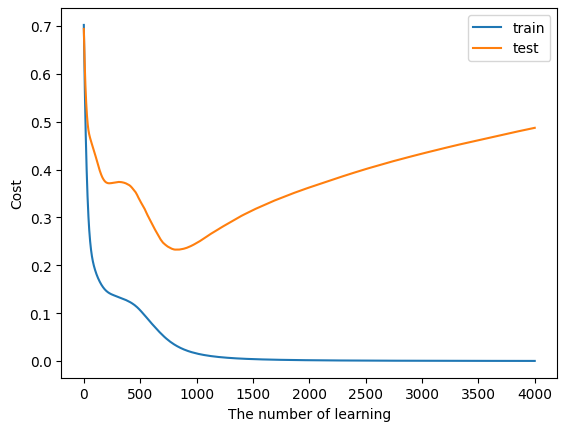

  * `Early stopping with patience`
    * **EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)**
      * patience=200 옵션을 추가하여 200 epoch 동안 `연속으로 loss증가`하면 학습을 멈춤
      * 나머지 코드 동일
    ```python
      >>> Epoch 922: early stopping
          Train acc: 1.0, Test acc: 0.9428571462631226
    ```
    * 기존의 227 epoch보다 늦은 922 epoch에서 멈춰, 훨씬 높은 94%의 Test accuracy

* train_test_split : 데이터를 나눌 때 무작위로 섞어서 나눌 수 있게 함
  ```python
    from sklearn.model_selection import train_test_split

    # train, test 나누기
    x_train, x_test = train_test_split(X, test_size=0.3)
    y_train, y_test = train_test_split(y, test_size=0.3)

    print(x_train.shape, x_test.shape)
    print(x_train.shape, y_test.shape)
    >>> (70, 2) (30, 2)
        (70, 2) (30,)

    # train, validation 나누기
    x_train, x_validate = train_test_split(x_train, test_size=0.3)
    y_train, y_validate = train_test_split(y_train, test_size=0.3)

    print(x_train.shape, x_validate.shape, x_test.shape)
    print(y_train.shape, y_validate.shape, y_test.shape)
    >>> (49, 2) (21, 2) (30, 2)
        (49,) (21,) (30,)
  ```

* Data Preprocessing(전처리)
  * **StandardScaler, MinMaxScaler의 약점 : outlier에 약하다**
    * 극단적인 데이터가 많지 않다면 적용해도 좋으며, 많다면 **robustscaler**도 고려
  ```python
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    # MinMaxScaler 적용 전 x
    print(x)
    >>> [[236.37372138  67.4728654  889.1062823  561.1353035  191.38532351]
        [746.36250159  92.35363502 128.54322612 108.49157384 353.10048148]
        [673.3844796  734.7410641  760.98411268 983.26464345 202.82746593]
        [803.57916563  79.26219033 691.56641875 860.20938727 637.68924843]
        [961.59849032 646.66721861 610.07133782 190.98379101 392.23091957]]

    # MinMaxScaler 적용 후 x : (x - min) / (max - min)
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    print(x_scaled)
    >>> [[0.         0.         1.         0.51744132 0.        ]
        [0.70321479 0.03728751 0.         0.         0.36234312]
        [0.60258664 1.         0.831543   1.         0.02563756]
        [0.78210986 0.01766805 0.74027155 0.85932894 1.        ]
        [1.         0.86800833 0.63312056 0.09430128 0.45001978]]

    # StandardScaler : (x - mean) / std
  ```
  

# 6주차 수업정리

## 자연어처리 관련 기초적인 내용

### 시계열데이터(Sequential Data)
* 시계열데이터(Sequential Data) : 문장(순서를 가진 단어들), 영상, 주가, 태풍의 이동경로 등 <br>
  (자연어처리도 시계열데이터의 하위분야 중 하나)

* 기본적으로 `Input - Output - 그 사이의 function` 을 파악하면 좋으며, 아래는 예시임
  * 태풍으로 인한 날짜별 피해액을 알고자 할 때 : Input도 Output도 시계열
  * 태풍의 소멸시기 예측 : Input은 시계열이지만 Output은 single output
  * 단어가 문법적으로 맞는지 : 시계열 문제
  * 문장의 주제가 어떤 것인지(과학? 문학?) : single output 
  * 그림을 묘사하는 문장 생성 : 시계열이 아닌 Input과 시계열인 Output

### Problem types 예시
* One-to-one : (Image classification) 숫자 이미지를 input으로 받아 정답 숫자를 output
* Many-to-one : (Frame → Class) 태풍의 이동경로, 속도를 input으로 하여 언제사라질지 output
* Many-to-many : (Frames → Classes) 태풍의 이동경로, 속도를 input으로 하여 날짜별 피해액 output
* One-to-many : (Image → Words. Image captioning) 고양이 사진을 input으로, 이에 대한 묘사 문장을 output
* Many-to-many : (Video → words. Video captioning) 5개 단어의 영어문장을 input으로, 3개 단어의 한글문장으로 output

### Word Embedding
* 단어를 모델에 인식시키려면 숫자로 매핑하는 과정이 필요
  (알파벳은 유니코드 등으로 표현이 되지만, 단어는 그렇지 못함)
* 숫자로 매핑하며 단어의 다양한 관계를 나타낼 수 있도록 벡터로 표현. 이를 `Word Embedding`이라고 함
  * 임의의 정수로 매핑할 때, 비슷한 단어일수록 숫자의 차이가 적게 만듦
    (baby 12, boy 13, child 14와 같이)
  * 다만 girl이라는 단어가 나온다면 문제가 생길 수 있음 
    (boy 옆에 이미 baby가 있음)
  * 해결방법 : 벡터로 만든다. 자릿수를 늘려 표현할 수 있는 관계가 많아짐 
    (boy[13,14], girl[14,13]과 같이 정의하면 벡터간 거리가 같다)
  * 다양한 관계로 나타낼 수 있도록 벡터로 표현하게 됨 (`Word Embedding`)
    (참고로 GPT는 512차원이나 768차원정도 됨)
* 처음엔 랜덤한 벡터였지만, 학습할수록 벡터가 변경되어 단어간의 관계를 표현

### Word2vec
* 가지고 있는 단어(토큰)를, 문장에 빈 칸을 두어 맞추게 함
  * 예를 들어 5만 개의 단어 중 정답인 into가 들어오지 않으면 감점 후 다시 학습(5만가지의 Classification)
* Word2vec이 아닌, 단어(토큰)를 주고 주변의 단어를 맞추게 하는 방법도 있지만 요즘은 많이 쓰지 않는 추세
* 언어모델의 학습은, 예를 들면 위키피디아의 문장을 가져와, 문장에 빈칸을 만들고 빈칸의 단어를 정답으로 만든 뒤, cross entropy 측정 등 진행
* Word2vec학습을 마치면 단어의 관계를 묘사하게 됨<br>
  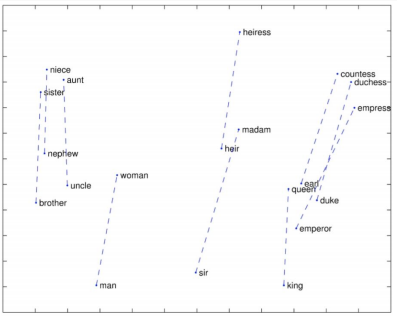

## RNN

### RNN을 활용한 감정분석 사례(Many-to-one)
* `RNN(Recurrent Neural Networks)`이라는 딥러닝으로 시계열을 처리하는 기초적인 architecture 적용
  (이미지와 달리 문장은 길이가 항상 바뀐다)
* 랜덤한 $h_0$을 시작으로, 현재의 단어 $x_1$부터 더해가면 최종적으로 $h_t$에 모든 문장의 정보가 들어있음
  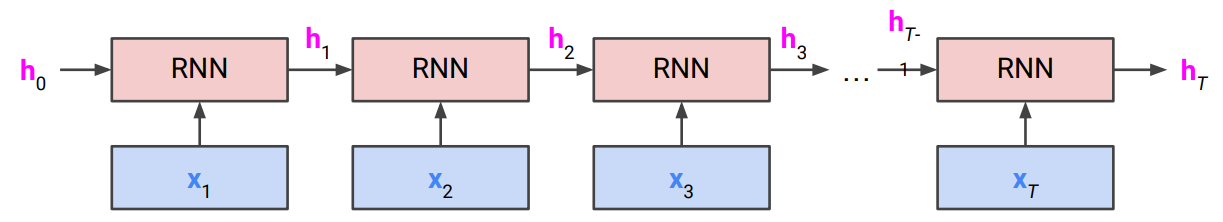
* 현재의 단어 $x_t$와, 이전까지의 단어들 $h_{t-1}$ 중 어떤 것을 더 많이 반영할지를 정하는 파라미터 $W_hh$, $W_xh$
  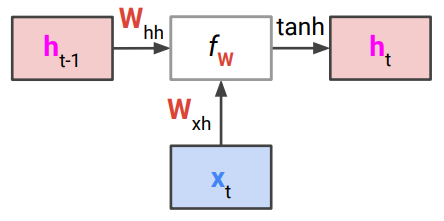
* 각 부분의 $W_hh$, $W_xh$는 동일한 값 (`Shared parameter`)
  예를 들어 $W_hh$값이 다르다면 단어의 수만큼 $W_hh$가 필요하며, 문장길이가 바뀔 때마다 학습을 다르게 해야함
  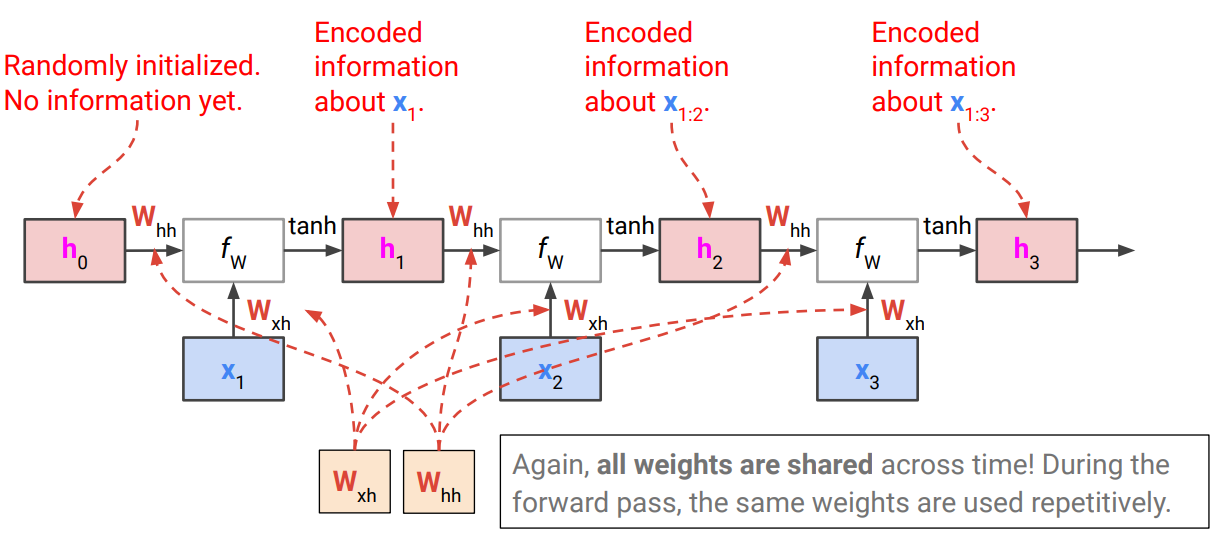
* Sigmoid함수를 통과하여 0.5를 기준으로 긍정/부정 등을 평가하여 감정분석하는 방식 적용
* Backpropagation(Chain rule)을 사용해 학습

### RNN을 활용한 Many-to-many 적용케이스 (태풍의 날짜별 피해액 등)
* hidden state($h_1$)마다 예측($\hat{y}$)을 하고, 예측에 대해 실제값과 cross entropy비교 및 Backpropagation
  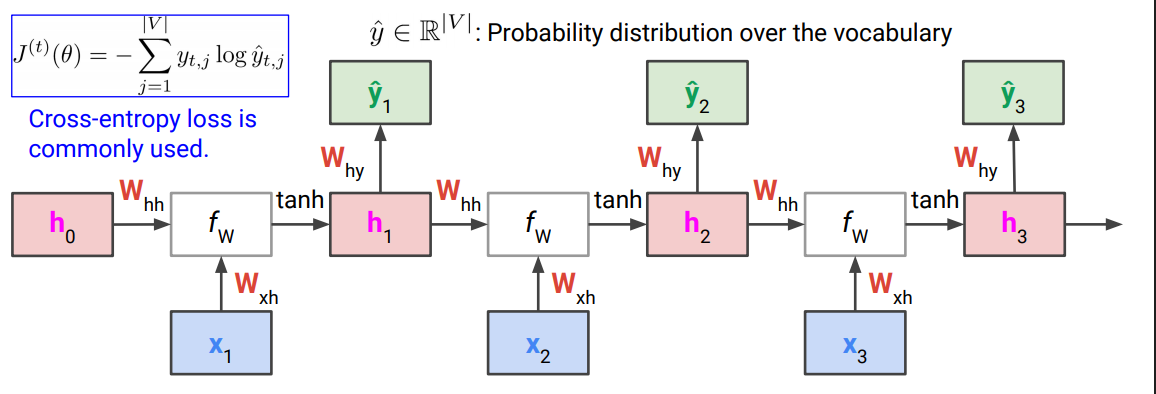<br>
* Multi-layer RNN<br>
  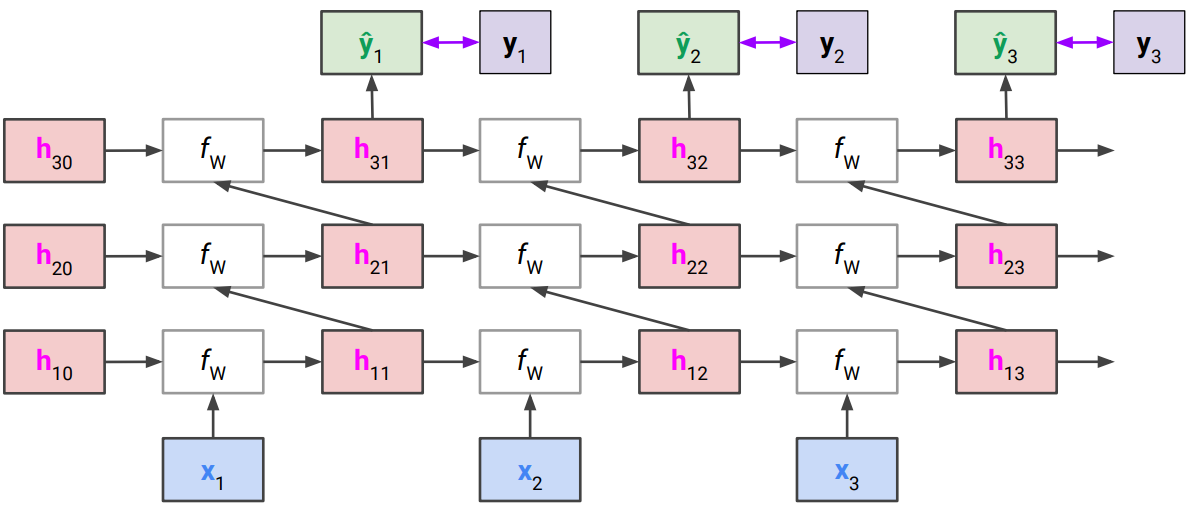<br>
* RNN의 장단점
  * 장점
    * Input(문장의 길이 등)이 다른 문제에 대해 대처가 가능
    * Parameter share로 모델의 크기가 커지지 않게 됨
    * (이론적으로) 마지막 step에는 모든 정보가 들어있게 됨
  * 단점
    * 느리다
    * `Vanishing gradient`(학습이 안됨) : 미분값이 0에 수렴하여 학습이 일어나지 않음 (↔ Exploding gradient)
    * `long-range dependency`(장기기억 소실, 학습은 되지만 초반부는 잊음) : 문장 초반부의 단어는 0에 수렴하며 잊게되고, 후반부의 내용만 잘 전달됨

### LSTM(Long Short Term Memory)
* 장기기억을 잊는 문제를 해결하기 위해, 보존할 수 있는 (장기기억만을 담당하는)cell gate 추가
  (RNN의 핵심적 아이디어를 조금 발전시킨 것)
* 문제
  * 여전히 `Vanishing gradient`는 존재함
  * `long-range dependency`도 문장이 너무 길어지면 다시 발생
* `Transformer가 등장하며 잘 안쓰이게 되었음`

### GRU(Gated Recurrent Units)
* LSTM보다 간소화되었음
* `Transformer가 등장하며 잘 안쓰이게 되었음`
* 다만 LSTM이나 GRU 모두 선박이나 태풍의 이동경로 등의 작은 규모는 적용할만 함 (Transformer는 상당히 큰 모델임)
  * 자연어는 Transformer 사용(위의 사례도 Transformer사용시 더 좋아짐)